In [1]:
import numpy as np
from Receiver import Softmax
import json
from tqdm.notebook import tqdm
from forest.benchmarking.distance_measures import total_variation_distance
from utils import *
import torch

In [ ]:
prior = np.load("../data/8_8/prior.npy")
utility_sender = np.load("../data/8_8/utilities_s.npy")
utility_receiver = np.load("../data/8_8/utilities_r.npy")

sample_prior = prior[0]
sample_sender = utility_sender[0]
sample_receiver = utility_receiver[0]
sample_size = 1000
t = 50
commitments = genCommitment(8, 8, 10)
collect_data = []

for commitment in tqdm(commitments):
    tester = Tester(8, 8, sample_size, t)
    _, data = interact_with_receiver(tester, commitment, sample_prior, sample_receiver, 8, 8, 0.1, 100000, sample_size)
    collect_for_training(commitment, collect_data, data, 8, 8)

In [9]:
def add_to_train(dataset, commitment, data, m_dim, a_dim, s_dim):
    new_train = []
    message_stat = set()
    probability = np.zeros((m_dim, a_dim))
    for i in data:
        action = i % m_dim
        message = i // m_dim
        message_stat.add(message)
        probability[message, action] += 1
    for i in range(m_dim):
        if(np.sum(probability[i]) != 0):
            probability[i] = probability[i] / np.sum(probability[i])
    for message in message_stat:
        tmp = commitment[:, message].tolist()
        tmp.extend(probability[message].tolist())
        new_train.append(tmp)
    new_train = torch.FloatTensor(new_train)
    dataset.x = torch.cat((dataset.x, new_train[:, 0:s_dim]), dim = 0)
    dataset.y = torch.cat((dataset.y, new_train[:, s_dim:]), dim = 0)


In [5]:
import numpy as np
from torch.utils.data import DataLoader
from dataset import dataset
def split_train_val(collect_data, val_size, s_dim):
    tmp = np.array(collect_data)
    total_sample = len(tmp)
    np.random.shuffle(tmp)
    val_size = int(total_sample * val_size)
    train_data = tmp[val_size : , :]
    val_data = tmp[:val_size, :]
    train_set = dataset(train_data, s_dim)
    val_set = dataset(val_data, s_dim)
    return train_set, val_set
    
def build_dataloader(trainset, valset, batch_size, s_dim):
    train_loader = DataLoader(trainset, batch_size = batch_size, shuffle=True)
    val_loader = DataLoader(valset, batch_size = batch_size, shuffle=False)
    return train_loader, val_loader

In [6]:
import torch.nn as nn
class Receiver_Model(nn.Module):
    def __init__(self, s_dim, a_dim):
        super(Receiver_Model, self).__init__()
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.linear = nn.Linear(s_dim, a_dim)
        # self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.linear(x)
    
    def __criterion__(self, logits, labels):
        log_softmax = F.log_softmax(logits, dim = -1)
        return -torch.mean(torch.sum(log_softmax * labels, dim = -1))
    
    def train(self, dataloader_train, dataloader_val, learning_rate, epochs, early_stopper):
        opt_rm = torch.optim.RMSprop(self.parameters(), lr = learning_rate)
        criterion = self.__criterion__
        for epoch in range(epochs):
            train_loss = self.__train_one_epoch__(dataloader_train, opt_rm, criterion)
            val_loss = self.__val_one_epoch__(dataloader_val, criterion)
            print(f"train loss: {train_loss}, val loss: {val_loss}")
            if early_stopper.early_stop(val_loss):
                break
            
    def __train_one_epoch__(self, dataloader_train, opt_rm, criterion):
        train_loss = 0
        for i, (feature, label) in enumerate(dataloader_train):
            pred_logit = self.forward(feature.float())
            loss = criterion(pred_logit, label)
            opt_rm.zero_grad()
            loss.backward()
            opt_rm.step()
            train_loss += loss.item()
        return (train_loss / (i+1))
    
    def __val_one_epoch__(self, dataloader_val, criterion):
        with torch.no_grad():
            val_loss = 0
            for i, (feature, label) in enumerate(dataloader_val):
                pred_logit = self.forward(feature.float())
                loss = criterion(pred_logit.float(), label)
                val_loss += loss.item()
            return (val_loss / (i+1))

In [7]:

from Receiver_Model import Receiver_Model
import torch
from Sender import Sender
train_data, val_data = split_train_val(collect_data, 0.2, 8)
train_loader, val_loader = build_dataloader(train_data, val_data, 32, 8)
receiver_model = Receiver_Model(8, 8)
earlystopper = EarlyStopper(10, 0.01)
train_losses = receiver_model.train(train_loader, val_loader, 0.0025, 100, earlystopper)
sender = Sender(8, 8, sample_prior, sample_sender)
opt_s = torch.optim.RMSprop(sender.parameters(), lr = 0.01)
losses = sender.update_sender(receiver_model, 10000, earlystopper, opt_s)

In [ ]:
receiver_model = Receiver_Model(8, 8)
earlystopper = EarlyStopper(20, 0.01)
trian_losses = receiver_model.train(train_loader, val_loader, 0.0025, 100, earlystopper)

In [10]:
# 进一步判断
while True:
    sender = Sender(8, 8, sample_prior, sample_sender)
    opt_s = torch.optim.RMSprop(sender.parameters(), lr = 0.01)
    losses = sender.update_sender(receiver_model, 10000, earlystopper, opt_s)
    predicted_reward = -losses[-1]
    commitment = sender(torch.FloatTensor([1])).detach().numpy()
    states, actions = interact_with_receiver(tester, commitment, sample_prior, sample_receiver, 8, 8, 0.1, 1000000, 20000)
    actual_reward = []
    for state, action in zip(states, actions):
        actual_reward.append(sample_sender[state, action % 8])
    actual_reward = np.mean(actual_reward)
    print(f"predicted_reward: {predicted_reward}, actual_reward: {actual_reward}")
    if(abs(predicted_reward - actual_reward) < 0.05):
        break
    else:
        add_to_train(train_data, commitment, actions, 8, 8, 8)
        receiver_model.train(train_loader, val_loader, 0.0025, 100, earlystopper)

predicted_reward: 0.6944105625152588, actual_reward: 0.6373838691010781
predicted_reward: 0.6941384077072144, actual_reward: 0.631381095155172
predicted_reward: 0.6945748329162598, actual_reward: 0.6350374286858342
predicted_reward: 0.6940716505050659, actual_reward: 0.6231817585196064
predicted_reward: 0.6936026811599731, actual_reward: 0.6317792441573319
predicted_reward: 0.6936671733856201, actual_reward: 0.6378283621155075
predicted_reward: 0.6945618987083435, actual_reward: 0.6405918266048889
predicted_reward: 0.6945205926895142, actual_reward: 0.6444606429751056
predicted_reward: 0.6935234665870667, actual_reward: 0.6340813557813406
predicted_reward: 0.6941171884536743, actual_reward: 0.636555180521055
predicted_reward: 0.6943650245666504, actual_reward: 0.6351416652208384
predicted_reward: 0.639220118522644, actual_reward: 0.5185107351713888
predicted_reward: 0.6937130093574524, actual_reward: 0.6077344342210959
predicted_reward: 0.693414032459259, actual_reward: 0.6456663054094

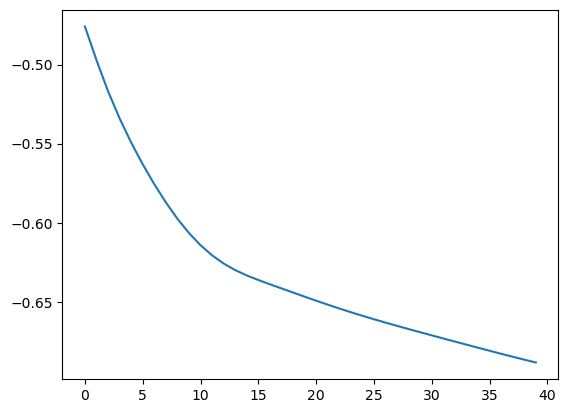

In [36]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [38]:
losses[-20:]

[-0.6492596864700317,
 -0.6517616510391235,
 -0.6541854739189148,
 -0.6565258502960205,
 -0.658784806728363,
 -0.6609698534011841,
 -0.663090705871582,
 -0.6651589274406433,
 -0.6671859622001648,
 -0.6691827774047852,
 -0.6711593866348267,
 -0.6731229424476624,
 -0.6750783920288086,
 -0.6770275831222534,
 -0.6789683699607849,
 -0.6808961629867554,
 -0.6828032732009888,
 -0.684680163860321,
 -0.6865167021751404,
 -0.688302218914032]

In [12]:
import torch.nn.functional as F
y_pred = F.softmax(receiver_model(x), dim=-1).detach().numpy()

NameError: name 'x' is not defined

In [42]:
y - y_pred

tensor([[-1.7262e-02, -1.1790e-02,  2.9151e-01, -2.1977e-02, -1.3125e-03,
         -6.5711e-02, -1.8327e-01,  9.8181e-03],
        [ 6.3759e-03,  5.6982e-03, -5.2650e-02, -1.2104e-02,  6.5703e-03,
          2.0478e-02,  2.4792e-02,  8.4014e-04],
        [-1.2354e-01,  5.1218e-03,  7.4058e-02, -4.6877e-02, -8.7101e-05,
          1.2475e-02,  8.3517e-02, -4.6641e-03],
        [ 3.5073e-02,  1.5291e-02,  2.3572e-02,  7.4605e-02, -9.6638e-03,
          2.3897e-01, -3.7894e-01,  1.0938e-03],
        [ 4.2514e-02, -1.9412e-03,  6.2161e-02,  3.2948e-02,  2.2620e-04,
          8.4018e-02, -2.2012e-01,  1.9288e-04],
        [-3.3054e-03,  2.6592e-03, -1.7397e-02,  1.2524e-02,  3.4753e-03,
          1.2239e-03, -1.5297e-03,  2.3495e-03],
        [-2.8800e-02,  1.6854e-03,  9.4075e-02, -1.8499e-02,  8.3438e-03,
         -3.6150e-02, -1.7014e-02, -3.6423e-03],
        [-9.0821e-03, -3.7916e-02, -4.2400e-02, -6.7742e-03,  9.5034e-03,
          1.4029e-03,  8.6857e-02, -1.5918e-03],
        [ 2.4961

In [28]:
x, y = next(iter(train_loader))

In [11]:
-torch.mean(torch.sum(y * torch.log(y), dim=-1))

tensor(nan)

In [14]:
for i in torch.log(y)* y:
    print(i)

tensor([-0.0623, -0.0664, -0.1203, -0.0400, -0.0303, -0.0296, -0.1788, -0.0547])
tensor([-0.3675, -0.0616, -0.3660, -0.2770, -0.0240, -0.1252, -0.1740, -0.0808])
tensor([-0.2629, -0.0759, -0.3396, -0.2708, -0.1005, -0.3444, -0.3221, -0.0498])
tensor([-0.1836, -0.1025, -0.3679, -0.1918, -0.1102, -0.2618, -0.3585, -0.0564])
tensor([-0.0708, -0.0582, -0.2316, -0.0765, -0.1442, -0.1066, -0.2592, -0.0789])
tensor([-0.2240, -0.1547, -0.2701, -0.1133, -0.0343, -0.2421, -0.3243, -0.0343])
tensor([-0.2120, -0.0740, -0.3608, -0.2591, -0.1022, -0.3097, -0.3461, -0.0575])
tensor([-0.1567, -0.1506, -0.2827, -0.1318, -0.0279, -0.1905, -0.2939, -0.0223])
tensor([-0.2844, -0.1416, -0.3679, -0.1897, -0.0577, -0.1909, -0.3457, -0.1014])
tensor([-0.1915, -0.1515, -0.3654, -0.1604, -0.0576, -0.1164, -0.3669, -0.0783])
tensor([-0.3678, -0.0285, -0.3679, -0.2736, -0.0181, -0.0966, -0.2025, -0.0663])
tensor([-0.2190, -0.0407, -0.3058, -0.1846, -0.1088, -0.1078, -0.2739, -0.1010])
tensor([-0.2048, -0.1437, -0

In [32]:
import torch.nn.functional as F
F.softmax(receiver_model(x), dim=-1)

tensor([[1.0638e-01, 2.2925e-02, 3.9212e-01, 7.6944e-02, 1.4478e-02, 9.1602e-02,
         2.8208e-01, 1.3471e-02],
        [7.1209e-02, 2.8188e-02, 4.2392e-01, 6.3869e-02, 2.7427e-02, 1.0915e-01,
         2.6374e-01, 1.2500e-02],
        [3.4865e-01, 8.3118e-03, 2.2448e-01, 2.0872e-01, 1.9687e-02, 1.2111e-01,
         4.7355e-02, 2.1688e-02],
        [6.7688e-02, 2.4901e-02, 8.2535e-02, 9.0543e-02, 1.2620e-02, 3.3769e-01,
         3.7888e-01, 5.1394e-03],
        [1.0291e-02, 3.8186e-02, 5.8180e-03, 1.1704e-02, 2.0474e-04, 6.4662e-02,
         8.6872e-01, 4.1857e-04],
        [1.9072e-01, 1.9930e-02, 2.8195e-01, 1.5928e-01, 3.6417e-02, 1.6528e-01,
         1.2081e-01, 2.5596e-02],
        [4.6798e-02, 2.9037e-02, 5.2705e-01, 3.7171e-02, 2.3672e-02, 6.4403e-02,
         2.5956e-01, 1.2309e-02],
        [1.0003e-01, 3.8414e-02, 2.4151e-01, 8.7213e-02, 1.7247e-02, 1.3865e-01,
         3.6791e-01, 9.0248e-03],
        [2.3129e-02, 1.5567e-02, 7.2204e-01, 2.1913e-02, 8.3129e-02, 4.4185e-02,

In [33]:
y

tensor([[8.9814e-02, 1.0953e-02, 6.8127e-01, 5.4765e-02, 1.3143e-02, 2.6287e-02,
         1.0077e-01, 2.3001e-02],
        [7.8210e-02, 3.3852e-02, 3.6926e-01, 5.1556e-02, 3.3852e-02, 1.3171e-01,
         2.8833e-01, 1.3230e-02],
        [2.1877e-01, 1.3649e-02, 3.0037e-01, 1.5839e-01, 1.9835e-02, 1.4081e-01,
         1.3128e-01, 1.6889e-02],
        [1.0218e-01, 3.9992e-02, 1.0563e-01, 1.6418e-01, 2.8703e-03, 5.7903e-01,
         0.0000e+00, 6.1232e-03],
        [5.2654e-02, 3.6340e-02, 6.8019e-02, 4.4540e-02, 4.3159e-04, 1.5045e-01,
         6.4696e-01, 6.0423e-04],
        [1.8541e-01, 2.2703e-02, 2.6424e-01, 1.6943e-01, 3.9941e-02, 1.7091e-01,
         1.1982e-01, 2.7538e-02],
        [1.8688e-02, 3.0581e-02, 6.1910e-01, 1.8688e-02, 3.1940e-02, 2.8882e-02,
         2.4363e-01, 8.4947e-03],
        [9.1843e-02, 3.2113e-04, 1.9750e-01, 8.0283e-02, 2.6654e-02, 1.4226e-01,
         4.5376e-01, 7.3860e-03],
        [2.6003e-02, 1.5319e-02, 7.1296e-01, 1.2296e-02, 9.5344e-02, 4.0113e-02,

In [ ]:
receiver_model

In [21]:
y[0]

tensor([0.0439, 0.0551, 0.1177, 0.0226, 0.0000, 0.0000, 0.7577, 0.0029])

In [19]:
receiver_model(x)

tensor([[-3324.9272, -3331.3442, -3351.8130,  3381.1855, -3298.8696, -3330.3701,
         -3352.1514, -3346.3291],
        [-3273.6982, -3287.1152, -3300.3022,  3330.2056, -3249.0610, -3279.6140,
         -3304.7144, -3295.7524],
        [-3159.1570, -3173.1387, -3184.6006,  3213.2012, -3135.3569, -3164.6450,
         -3188.8984, -3179.9663],
        [-3616.0815, -3631.8931, -3643.6934,  3679.6396, -3570.8247, -3619.0718,
         -3655.8657, -3635.8892],
        [-3570.6733, -3585.9004, -3600.4749,  3635.8220, -3532.5920, -3573.8384,
         -3606.4717, -3593.9678],
        [-3078.4622, -3092.0408, -3102.8291,  3134.8965, -3048.7363, -3085.7444,
         -3110.7041, -3099.1521],
        [-4804.8965, -4821.7622, -4843.0859,  4894.4033, -4746.5308, -4812.4785,
         -4854.4463, -4839.9189],
        [-5025.8174, -5051.8027, -5057.9990,  5113.4482, -4979.7837, -5041.3467,
         -5079.2402, -5057.9590],
        [-4232.7686, -4248.3379, -4279.9785,  4315.9756, -4184.6748, -4233.8398,

In [8]:
-torch.mean(torch.sum(y * F.log_softmax(receiver_model(x), dim=-1), dim=-1))

tensor(7383.5698, grad_fn=<NegBackward0>)

In [ ]:
F.log_softmax()

In [9]:
y

tensor([[0.0148, 0.0161, 0.8710, 0.0084, 0.0059, 0.0057, 0.0657, 0.0125],
        [0.3855, 0.0146, 0.3314, 0.1419, 0.0044, 0.0384, 0.0629, 0.0209],
        [0.1278, 0.0192, 0.2335, 0.1354, 0.0281, 0.2446, 0.2003, 0.0111],
        [0.0684, 0.0289, 0.3695, 0.0735, 0.0320, 0.1267, 0.2879, 0.0130],
        [0.0175, 0.0135, 0.7272, 0.0194, 0.0473, 0.0306, 0.1243, 0.0202],
        [0.0953, 0.0525, 0.1347, 0.0333, 0.0069, 0.1094, 0.5610, 0.0069],
        [0.0867, 0.0185, 0.2982, 0.1242, 0.0288, 0.1815, 0.2488, 0.0133],
        [0.0535, 0.0504, 0.1479, 0.0414, 0.0053, 0.0727, 0.6247, 0.0040],
        [0.1498, 0.0460, 0.3695, 0.0721, 0.0134, 0.0729, 0.2478, 0.0285],
        [0.0733, 0.0508, 0.4112, 0.0555, 0.0134, 0.0346, 0.3412, 0.0200],
        [0.3608, 0.0055, 0.3694, 0.1383, 0.0031, 0.0266, 0.0803, 0.0161],
        [0.0916, 0.0085, 0.6013, 0.0691, 0.0314, 0.0311, 0.1386, 0.0283],
        [0.0818, 0.0470, 0.1307, 0.0720, 0.0090, 0.1466, 0.5065, 0.0064],
        [0.3041, 0.0353, 0.1614, 0.255

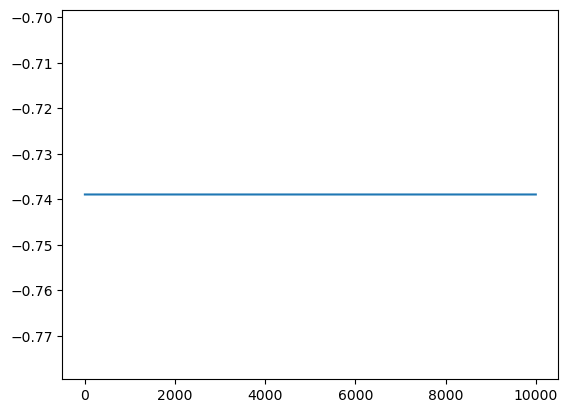

In [24]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [8]:
predicted_reward, actual_reward

(0.7389365434646606, 0.4808103939038986)